# Data exportation

As our work start to deal with machine learning training we have seen some memory issues. 

**Main goals are**: 

- Reduce image size
- Regenerate masks


**Remainder:**


<pre>
The width is around 1327.88px with 363.5px standard deviation \n
     (min val is 384px with 2916px max val)
     (common val could be around 1691.38px)
</pre>

<pre>
The height is around 970.69px with 383.39px standard deviation
     (min val is 127px with 2713px max val)
     (common val could be around 1354.08px)
</pre>

**Around 970 * 1300 px = 0.74 ratio**

In [1]:
# We keep aspect ratio of images and scales them down
common_width = 220
common_height = 163
# max_iter = 50

In [10]:
import os
import pandas as pd
from PIL import Image
from local_lib.images import resize_image
from local_lib.images import image_to_dataframe

def process_images(imgs_folder, dest_folder_dfs):
    """
    Process all images in the given folder.
    """
    # Get all image file names
    image_files = [f for f in os.listdir(imgs_folder) if os.path.isfile(os.path.join(imgs_folder, f))]
    
    # Find the size of the largest image
    max_width = common_width
    max_height = common_height
    
    # n_iter = 0
    # Process each image
    for image_file in image_files:
        # if(n_iter >= max_iter):
        #     break
        # n_iter += 1
        with Image.open(os.path.join(imgs_folder, image_file)) as img:
            # Resize the image
            img_resized = resize_image(os.path.join(imgs_folder, image_file), (max_width, max_height))
            # Convert the resized image to grayscale DataFrame
            df = image_to_dataframe(img_resized)
            # Save the DataFrame to a CSV file
            df.to_csv(os.path.join(dest_folder_dfs, "processed_df_" + image_file.split('.')[0] + ".csv"), index=False)


# Set source and destination folders
imgs_folder = "../../datasets/chest_Xray/raw_data"
dest_folder_dfs = "../../datasets/chest_Xray/_processed_resize_small/_processed_dfs"

if not os.path.exists(dest_folder_dfs):
    os.makedirs(dest_folder_dfs)

# Process images
process_images(imgs_folder, dest_folder_dfs)

## **3m31s** execution against **87min** and **900Mo** against **58Go** 
A lot of gains from this operation, hope to note deterior the data too much

**Regenerate data masks**

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import time

start_time = time.time()

dest_folder_dfs = "../../datasets/chest_Xray/_processed_resize_small/_processed_dfs"

csv_files = [f for f in os.listdir(dest_folder_dfs) if os.path.isfile(os.path.join(dest_folder_dfs, f))]

images_sum = pd.DataFrame()

for csv_file in csv_files:
    csv_path = os.path.join(dest_folder_dfs, csv_file)
    df = pd.read_csv(csv_path)
    if images_sum.empty:
        images_sum = df
    else:
        images_sum += df


end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

Execution time: 34.44184446334839 seconds


**Showing superposition of new images**

Max value is 1159440


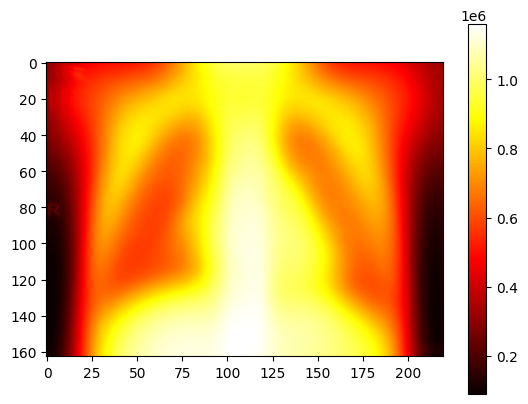

In [4]:
from local_lib.common import common_height, common_width

image = images_sum.values.reshape(common_height, common_width)
print("Max value is " + str(image.max()))
plt.imshow(image, cmap='hot')
plt.colorbar()

In [8]:
image_adjusted = images_sum.copy()
image_adjusted.max()

Pixel_Value    1159440
dtype: int64

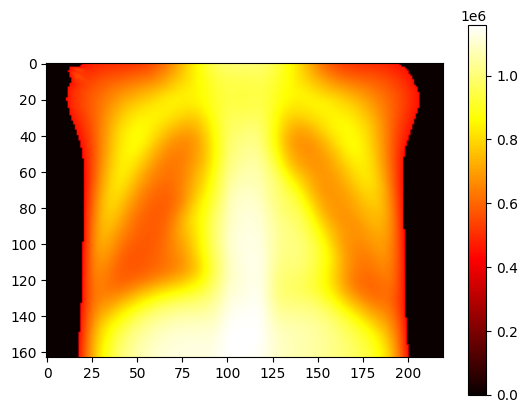

In [15]:
image_adjusted = images_sum.copy()
image_adjusted[image_adjusted < 450000] = 0


image_cropped = image_adjusted.values.reshape(common_height, common_width)

df = pd.DataFrame(image_cropped)
df = df.clip(lower=None, upper=1)
df.to_csv(os.path.join("../../datasets/chest_Xray/_processed_resize_small/", "data_mask_seuil.csv"), index=False)

plt.imshow(image_cropped, cmap='hot')
plt.colorbar()

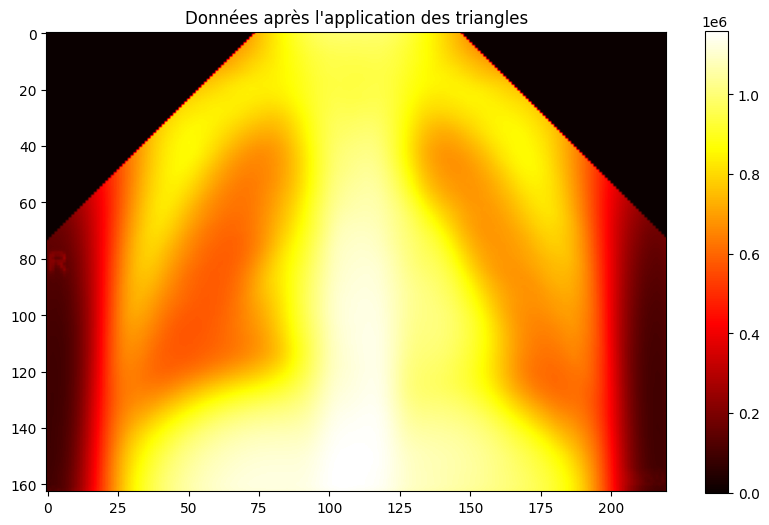

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

def determinant(p1, p2, p):
    return (p2[0] - p1[0]) * (p[1] - p1[1]) - (p[0] - p1[0]) * (p2[1] - p1[1])


def adapt_triangle(tableau, s1, s2, s3):
    rows = len(tableau)
    columns = len(tableau[0])
    
    for i in range(rows):
        for j in range(columns):

            coord = (i, j)
            

            det1 = determinant(s1, s2, coord)
            det2 = determinant(s2, s3, coord)
            det3 = determinant(s3, s1, coord)

            if (det1 >= 0 and det2 >= 0 and det3 >= 0) or (det1 <= 0 and det2 <= 0 and det3 <= 0):
                tableau[i][j] = 0

    return tableau


# Exemple d'utilisation :
data =  images_sum.copy().values.reshape(common_height, common_width)

result = adapt_triangle(data,(0, 0), (0, common_width/3), (common_width/3, 0))
result = adapt_triangle(data,(0, (common_width/3)*2), (0, common_width), (common_width/3, common_width))

df = pd.DataFrame(result)
df = df.clip(lower=None, upper=1)
df.to_csv(os.path.join("../../datasets/chest_Xray/_processed_resize_small/", "data_mask_triangle.csv"), index=False)

# Affichage du résultat avec Matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(result, cmap='hot')
plt.colorbar()
plt.title('Données après l\'application des triangles')
plt.show()

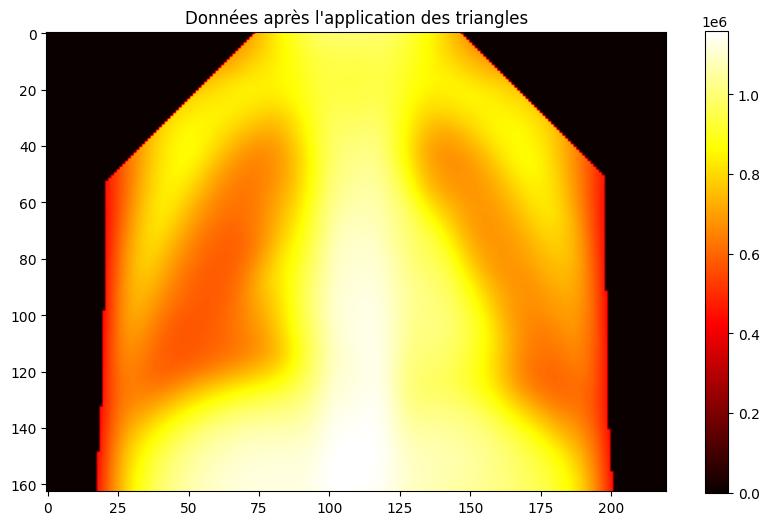

In [17]:
data =  image_cropped.copy()

result = adapt_triangle(data,(0, 0), (0, common_width/3), (common_width/3, 0))
result = adapt_triangle(data,(0, (common_width/3)*2), (0, common_width), (common_width/3, common_width))

df = pd.DataFrame(result)
df = df.clip(lower=None, upper=1)
df.to_csv(os.path.join("../../datasets/chest_Xray/_processed_resize_small/", "data_mask_seuil_triangle.csv"), index=False)


# Affichage du résultat avec Matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(result, cmap='hot')
plt.colorbar()
plt.title('Données après l\'application des triangles')
plt.show()

**Test filters on random images**

In [2]:
# Retreiving a significative amount of data
from local_lib.dataset import retreiveDatasetFromCsv

dataset = retreiveDatasetFromCsv()

In [14]:
from local_lib.flatten_transformer import FlattenTransformer
from sklearn.pipeline import Pipeline
import numpy as np

pipeline = Pipeline([
    ('image_mask', FlattenTransformer()),
])

# Fit and transform data
X = pipeline.fit_transform(dataset["pixel_value"])
y = np.array(list(dataset["class"]))

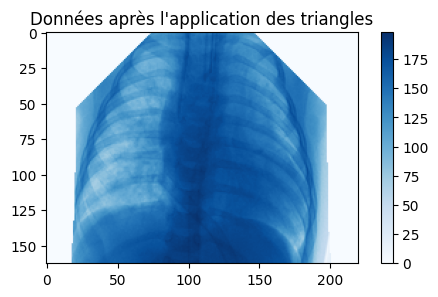

In [110]:
from local_lib.mask_transformer import MaskSeuilTransformer
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

mask_transformer = MaskSeuilTransformer(strategy='combined')

image = X[np.random.randint(0, len(dataset))]

result = mask_transformer.fit_transform([image])

result = result.reshape(common_height, common_width)

# Affichage du résultat avec Matplotlib
plt.figure(figsize=(6, 3))
plt.imshow(result, cmap='Blues')
plt.colorbar()
plt.title('Données après l\'application des triangles')
plt.show()